 Action detection, and classifications in videos

A video classification problem is not very different from an image classification problem. 
For an image classification task, we take images, use feature extractors, for example convolutional neural networks, to extract image features, and then the image is classified based on these extracted features. 
A simple way to deal with video classification, we need to extract the frames from the video and then we apply the same process as per image classification.

This notebook uses the [UCF101 – Action Recognition Data Set](https://www.crcv.ucf.edu/data/UCF101.php).

The dataset consists of 13,320 videos between ~2-10 seconds long of humans performing one of 101 possible actions. The dimensions of each frame are 320 by 240.

## Helper functions

In [205]:
import os
import numpy as np
import cv2
import time
import h5py
import sys

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
#from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.distributed as dist
import torchvision  # used to download the model

from skimage import io, transform



#from multiprocessing import Pool

In [206]:
print(cv2.__version__)

4.1.2


### Preparing the data

The following function uses a text file provided with the dataset
    which lists all of the relative paths for the videos for the train/test split. 
This function can be called with the location of the dataset 
(../data/UCF101/) and returns filenames and classes associated.

In [11]:
def getUCF101(base_directory = '', remove_classname = True):
    """
    This function uses a text file provided with the dataset
    which lists all of the relative paths for the videos for the train/test split. 
    This function can be called with the location of the dataset 
    (../data/UCF101/) and returns three variables:
    - class_list is a list of the action categories. 
    - train is a tuple. 
      The first element is a numpy array with the absolute 
      filepaths for the videos for training. 
      The second element is a numpy array of class indices (0-100). 
    - test is a tuple in the same format as train but for the test dataset.
    """

    # action class labels
    class_file = open(base_directory + 'ucfTrainTestlist/classInd.txt','r')
    lines = class_file.readlines()
    lines = [line.split(' ')[1].strip() for line in lines]
    class_file.close()
    class_list = np.asarray(lines)

    # training data
    train_file = open(base_directory + 'ucfTrainTestlist/trainlist01.txt','r')
    lines = train_file.readlines()      
    if remove_classname:
        filenames = ['UCF101-videos/' + line.split(' ')[0].split('/')[1] for line in lines]
    else:
        filenames = ['UCF101-videos/' + line.split(' ')[0] for line in lines]
    y_train = [int(line.split(' ')[1].strip())-1 for line in lines]
    y_train = np.asarray(y_train)    
    filenames = [base_directory + filename for filename in filenames]
        
    
    train_file.close()

    train = (np.asarray(filenames),y_train)

    # testing data
    test_file = open(base_directory + 'ucfTrainTestlist/testlist01.txt','r')
    lines = test_file.readlines()
    filenames = ['UCF101-videos/' + line.split(' ')[0].strip() for line in lines]
    classnames = [filename.split('/')[1] for filename in filenames]
    
    if remove_classname:
        # remove the class name from the filename if needed.
        filenames = ['UCF101-videos/' + line.split(' ')[0].split('/')[1].strip() for line in lines]
    
    y_test = [np.where(classname == class_list)[0][0] for classname in classnames]
    y_test = np.asarray(y_test)
    filenames = [base_directory + filename for filename in filenames]
    test_file.close()

    test = (np.asarray(filenames),y_test)

    return class_list, train, test

In [12]:
class_list, train, test = getUCF101('../data/UCF101/')

### Load frame

The following function is used for loading a single frame from a particular video in the dataset. 

args is a tuple with the first argument being the location of a video (which is in train[0] and test[0] from the getUCF101() function) 
and the second argument specifies whether data augmentation should be performed. 

The video paths in train and test look something like this: `../data/UCF101/UCF101-videos/FloorGymnastics/v_FloorGymnastics_g23_c01.avi.`

A random frame is selected and if augment==True, the frame is randomly cropped, resized to the appropriate dimension for the model, flipped, and has its brightness adjusted. 

The frame is normalized based on the provided mean and std for the default PyTorch pretrained ResNet-50 model. 

Finally the data is returned and is a numpy array of size [3,224,224] of type np.float32. 


Note: The original dataset (which can be downloaded [here](https://www.crcv.ucf.edu/data/UCF101.php)) is relatively small (9.5GB). 
However, it can be extremely slow to load and decode video files from memory. 
Because of this, sometime (e.g. [here](https://courses.engr.illinois.edu/ie534/fa2019/AR.html)) video files are stored as numpy arrays of size [sequence_length,height,width,3].
This makes them very quick to load but extremely large (~500GB). 
In this case, the dataset is stored as hdf5 files.
This function can also convert the avi paths to hdf5.

In [13]:
def loadFrame(filename, filetype='avi'):
    """
    
    ref. VideoCapture property: https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-get
    """

    try:        
        if filetype == 'hdf5':
            ### load file from HDF5
            filename = filename.replace('.avi','.hdf5')
            filename = filename.replace('UCF101','UCF101-hdf5')
            h = h5py.File(filename,'r')
            nFrames = len(h['video']) - 1
            frame_index = np.random.randint(nFrames)
            frame = h['video'][frame_index]
        else:
            ### load file from AVI
            cap = cv2.VideoCapture(filename)   

            if not cap.isOpened(): 
                print(f"could not open {filename}") 
                return

            nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            #frameWidth   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            #frameHeight  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps     = cap.get(cv2.CAP_PROP_FPS)

            frame_index = np.random.randint(nFrames)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

            if cap.isOpened():
                frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
                ret, frame = cap.read()  

            cap.release()

                
        frame = frame.astype(np.float32)
     
    except ValueError as e:
        print(f"Exception: {filename} \n", e)
    except:
        print("Exception: " + filename)
        print("Unexpected error:", sys.exc_info()[0])
        frame = np.array([])
                
    return frame

Test the loadFrame function:

In [14]:
frame = loadFrame('../data/UCF101/UCF101-videos/v_ApplyEyeMakeup_g08_c01.avi',                  
                 filetype='avi')

In [15]:
def frameToImg(frame):
    # swap columns to be shown as image
    # frame = np.moveaxis(frame, 0, -1) # data = np.moveaxis(data, source, destination) 
    
    if type(frame) == torch.Tensor:
        frame = frame.data.numpy()
        frame = frame.transpose(1, 2, 0)
        
    n_frame = (frame-np.min(frame))/np.max(frame-np.min(frame))    
    return n_frame

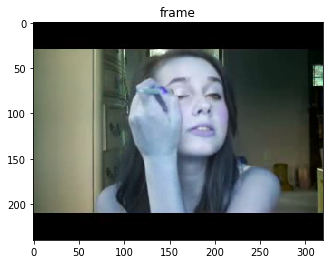

In [16]:
%matplotlib inline 

plt.imshow(frameToImg(frame))
plt.title('frame');

### Load a frame sequence

The following function is very similar to the loadFrame() function. 
The 3D ResNet-50 model is trained on sequences of length 16. 
This function simply grabs a random subsequence of frames and augments them all in the exact same way (this is important when performing data augmentation on videos). 
This function returns a numpy array of size [3,16,224,224]. 
The last three channels must be the time and space dimensions since the PyTorch 3D convolution implementation acts on the last three channels of an input with size [batch_size,num_of_input_features,time,height,width].

In [17]:
def loadSequence(filename, num_of_frames=16, augment=True, filetype='avi'):
    mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
    std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)

    curr_w = 320
    curr_h = 240
    height = width = 224
    
    data = np.zeros((3,num_of_frames,height,width),dtype=np.float32)

    try:
        if filetype == 'hdf5':
            ### load file from HDF5
            filename = filename.replace('.avi','.hdf5')
            filename = filename.replace('UCF-101','UCF-101-hdf5')
            h = h5py.File(filename,'r')
            nFrames = len(h['video']) - 1
            frame_index = np.random.randint(nFrames - num_of_frames)
            video = h['video'][frame_index:(frame_index + num_of_frames)]
        else:
            ### load file from AVI
            cap = cv2.VideoCapture(filename)   

            if not cap.isOpened(): 
                print(f"could not open {filename}") 
                return

            nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            #frameWidth   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            #frameHeight  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps     = cap.get(cv2.CAP_PROP_FPS)

            frame_index = np.random.randint(nFrames - num_of_frames)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

            video = []        
            f_count = 0
            while cap.isOpened() and f_count < num_of_frames:
                frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
                ret, frame = cap.read() 
                video.append(frame)
                f_count += 1
                
            cap.release()
            
        if(augment==True):
            ## RANDOM CROP - crop 70-100% of original size
            ## don't maintain aspect ratio
            resize_factor_w = 0.3*np.random.rand()+0.7
            resize_factor_h = 0.3*np.random.rand()+0.7
            w1 = int(curr_w*resize_factor_w)
            h1 = int(curr_h*resize_factor_h)
            w = np.random.randint(curr_w-w1)
            h = np.random.randint(curr_h-h1)
            random_crop = np.random.randint(2)

            ## Random Flip
            random_flip = np.random.randint(2)

            ## Brightness +/- 15
            brightness = 30
            random_add = np.random.randint(brightness+1) - brightness/2.0

            data = []
            for frame in video:
                if(random_crop):
                    frame = frame[h:(h+h1),w:(w+w1),:]
                if(random_flip):
                    frame = cv2.flip(frame,1)
                frame = cv2.resize(frame,(width,height))
                frame = frame.astype(np.float32)
                
                frame += random_add
                frame[frame>255] = 255.0
                frame[frame<0] = 0.0

                frame = frame/255.0
                frame = (frame - mean)/std
                data.append(frame)
            data = np.asarray(data)

        else:
            # don't augment
            data = []
            for frame in video:
                frame = cv2.resize(frame,(width,height))
                frame = frame.astype(np.float32)
                frame = frame/255.0
                frame = (frame - mean)/std
                data.append(frame)
            data = np.asarray(data)

        data = data.transpose(3,0,1,2)
    except:
        print("Exception: " + filename)
        data = np.array([])
    return data

Test the loadSequence function:

In [18]:
data = loadSequence('../data/UCF101/UCF101-videos/v_ApplyEyeMakeup_g08_c01.avi', 
                    num_of_frames=16,
                    augment=True, 
                    filetype='avi')

In [19]:
data.shape

(3, 16, 224, 224)

In [20]:
# swap columns to be shown as image
data = np.moveaxis(data, 0, -1)

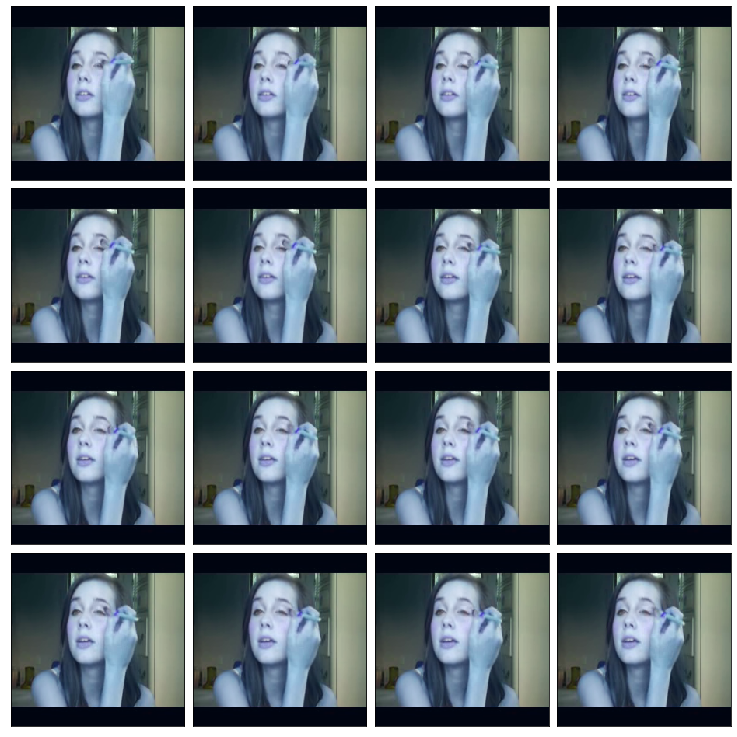

In [21]:
%matplotlib inline 

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

n_frames = data.shape[0]

max_frames = 16 # max number of frames to plot
for idx, frame in enumerate(data):  
    if idx < max_frames:
        plt.subplot(4, 4, idx+1, xticks=[], yticks=[])
        normalised_frame = (frame-np.min(frame))/np.max(frame-np.min(frame))
        plt.imshow( normalised_frame )
    else:
        break
    

### Using pytorch Dataset and DataLoaders

In [322]:
class SingleFrameDataset(Dataset):
    """Single frame dataset."""

#    def __init__(self, video_list, root_dir, transform=None):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            video_list (string): Path to the file with annotations.
            root_dir (string): Directory with all the videos.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.class_list, self.train_list, self.test_list = getUCF101(base_directory = root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.train_list[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        video_list = self.train_list[0][idx]
        frame = loadFrame(video_list, filetype='avi')
                                    
        label = self.train_list[1][idx]
        label = np.array([label])
#        label = label.astype('float').reshape(-1, 2)
        sample = {'image': frame, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
            

Creating transformations

In [323]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']        
        
#         # load frame has images as (channels x height x width).
#         # we need to transpose them.
#         #image = image.transpose(1, 2, 0)  # swap columns
        
#         # for images, x and y axes are axis 1 and 0 respectively
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        # for some reason the cv2.resize call fails when used in a DataLoader
            
#        img = img.transpose(2, 0, 1)   # swap columns to get back to the original dimensions

        return {'image': img, 'label': label}

In [336]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
            
        if h - new_h > 0:                
            top = np.random.randint(0, h - new_h)            
        else:
            top = 0

        if w - new_w > 0:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0

        # crop
        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'label': label}

In [337]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [338]:
class Normalize(object):
    """Normalises an image.
        
    Args:
        mean and std values. Deafult values based on the default pytorch 
        pretrained ResNet-50 model.       
    """

    def __init__(self, mean = np.asarray([0.485, 0.456, 0.406],np.float32),
                       std  = np.asarray([0.229, 0.224, 0.225],np.float32) ):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        ## resnet model was trained on images with mean subtracted
        image = image/255.0
        
        return {'image': (image - self.mean)/self.std,
                'label': label}

In [339]:
class RandomHorizontalFlip(object):
    """Randomly horizontally flip the image in a sample.  
    
    Args: prob of flipping the sample
    """
    def __init__(self, p_flip = .5):
        self.p = p_flip

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if np.random.uniform() <= self.p:
            image = cv2.flip(image, 1)  # one is horizontally                   
        
        return {'image': image, 'label': label}
    

We add one more helper funtion to show images

In [340]:
def show_image(image, label=None, normalize=True):
    """Show image with label"""
    
    if type(image) == torch.Tensor:
        image = image.data.numpy()
        image = image.transpose(1, 2, 0)
        
    if normalize:        
        image = (image-np.min(image))/np.max(image-np.min(image))    
    
    plt.imshow(image)
    if label: plt.title(label)
    plt.pause(0.001)  # pause a bit so that plots are updated

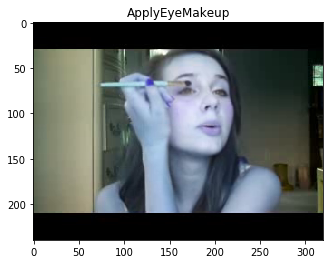

In [341]:
%matplotlib inline
frame = loadFrame('../data/UCF101/UCF101-videos/v_ApplyEyeMakeup_g08_c01.avi', filetype='avi')
show_image(frame, 'ApplyEyeMakeup', normalize=True)

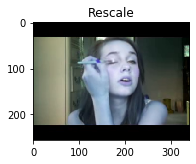

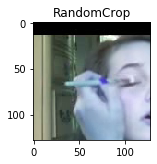

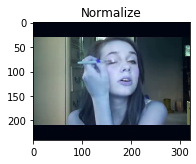

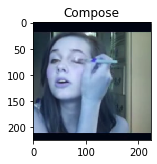

In [342]:
%matplotlib inline


scale = Rescale(256)
crop = RandomCrop(128)
normalize = Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

composed = transforms.Compose([Rescale(256),
                               RandomCrop(224),
                               RandomHorizontalFlip(1.),
                               Normalize()])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = {'image': loadFrame('../data/UCF101/UCF101-videos/v_ApplyEyeMakeup_g08_c01.avi', filetype='avi'), 
          'label': 0}

for i, tsfrm in enumerate([scale, crop, normalize, composed]):
    transformed_sample = tsfrm(sample)
    
    
    ax = plt.subplot(2, 2, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)

    # to check that Normalize() is working, call the function below with normalize=False
    show_image(**transformed_sample, normalize=True)


In [343]:
tsfms = transforms.Compose([Rescale(224),
                            RandomCrop(224),
                            RandomHorizontalFlip(.5),
                            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            ToTensor()])

In [344]:
train_ds = SingleFrameDataset('../data/UCF101/', transform=tsfms)
class_names = train_ds.class_list

In [345]:
def sampleToImg(sample):
    # swap columns to be shown as image
    frame = sample['image']
    
    if type(frame) == torch.Tensor:
        frame = frame.data.numpy()
        frame = frame.transpose(1, 2, 0)
        
    n_frame = (frame-np.min(frame))/np.max(frame-np.min(frame))
    return n_frame

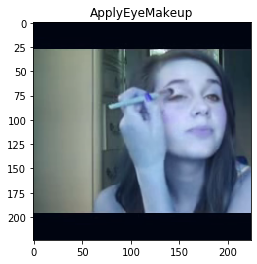

In [346]:
%matplotlib inline 

f_id = 1

plt.imshow(frameToImg(train_ds[f_id]['image']))
plt.title(train_ds.class_list[train_ds[f_id]['label']]);


`torch.utils.data.DataLoader` is an iterator which provides:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

this avoid losing a lot of features by using a simple for loop to iterate over the data.


One parameter of interest is `collate_fn`. You can specify how exactly the samples need to be batched using `collate_fn`. However, default collate should work fine for most use cases.

In [347]:
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

In [348]:
# Helper function to show a batch
def showBatch(sample_batched):
    """Show image for a batch of samples. Must be tensors of size (bs x channels x h x w)"""
    images_batch = sample_batched['image']
    labels_batch = sample_batched['label']
    
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(np.clip(grid.numpy().transpose((1, 2, 0)), 0,1))

    title_str = 'Classes: '
    for i in range(batch_size):
         title_str += train_ds.class_list[labels_batch[i][0].numpy()] + '(' + str(labels_batch[i][0].numpy()) + '); '
    plt.title(title_str)

0 torch.Size([4, 3, 224, 224])
1 torch.Size([4, 3, 224, 224])
2 torch.Size([4, 3, 224, 224])
3 torch.Size([4, 3, 224, 224])


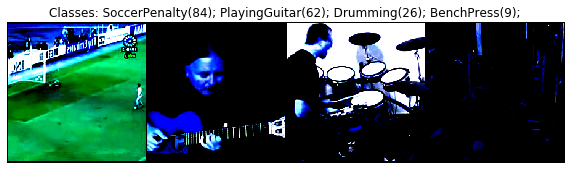

In [349]:
for i_batch, sample_batched in enumerate(train_dl):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(10,10))
        showBatch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [350]:
train_ds.class_list[65]

'PlayingTabla'

## Single frame model

This model uses a pretrained ResNet-50 model pretrained on ImageNet and bases the classification on feeding the network one frame at a time.

Although the dataset has a large number of frames (13000 videos * number of frames per video), the frames are correlated with eachother meaning there isn’t a whole lot of variety. Also, to keep the sequences relatively short (~2-10 seconds), some of the original videos were split up into 5-6 shorter videos meaning there is even less variety. 

Single frames alone can still provide a significant amount of information about the action being performed (consider the classes “Skiing” versus “Baseball Pitch”). Training a CNN from scratch significantly overfits. However, the features from a CNN pretrained on ImageNet (over 1 million images of 1000 classes) can be very useful even in video based problem like action recognition. A single frame model performs surprisingly well. This doesn’t necessarily mean solving the task of learning from images inherently solves all video related tasks. It’s more likely that with the problem of human action recognition, the spatial information is more important than the temporal information.

In [351]:
IMAGE_SIZE = 224
NUM_CLASSES = 101
batch_size = 100
lr = 0.0001
num_of_epochs = 10

In [352]:
data_directory = '../data/UCF101/'
class_list, train, test = getUCF101(base_directory = data_directory)

In [353]:
train_ds_size = len(train[0])

Load the model from torchvision.

Here is the link to the torch zoo of network models. It is worth taking a look at this page: [models](https://pytorch.org/docs/stable/torchvision/models.html).

Results are saved in: /Users/andreamunafo/.cache/torch/checkpoints/resnet50-19c8e357.pth

In [354]:
model = torchvision.models.resnet50(pretrained=True)

Replace the last fully connected layer to match the number of classes that we need. 

To do so we can use the name of the last layer (fc) and replace it with what we need.
To check the name we can simply run `model` in a cell.

In [355]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [356]:
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(2048, NUM_CLASSES) 

Freeze the parameters of the parts we do not want to train and set to true those of the last few layers that we are interested in updating.

The dataset is not large enough to warrant training a full ResNet-50 model. 

To start, we will just fine-tune the output layer and the last BottleNeck block (or residual block). `model.layer4` contains three residual blocks implying model.layer4[2] is the last of these three residual blocks. Fine-tuning only the top layers also reduces the amount of GPU memory, meaning a higher batch size can be used and the model can be trained more quickly with less overfitting.

In [357]:
for param in model.parameters():
    param.requires_grad_(False)

In [358]:
# for param in model.layer4[2].parameters():
#     param.requires_grad_(True)
for param in model.fc.parameters():
    param.requires_grad_(True)

In [359]:
params = []
# for param in model.conv1.parameters():
#     params.append(param)
# for param in model.bn1.parameters():
#     params.append(param)
# for param in model.layer1.parameters():
#     params.append(param)
# for param in model.layer2.parameters():
#     params.append(param)
# for param in model.layer3.parameters():
#     params.append(param)
for param in model.layer4[2].parameters():
    params.append(param)
for param in model.fc.parameters():
    params.append(param)

# model.cuda()

In [360]:
optimizer = optim.Adam(params, lr=lr)
criterion = nn.CrossEntropyLoss()

In [361]:
#pool_threads = Pool(8,maxtasksperchild=200)

### Training

In [364]:
model.train();

In [365]:
# # Get a batch of training data
# inputs = next(iter(train_dl))

In [366]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [370]:
def train_model(model, criterion, optimizer, num_epochs=num_of_epochs):
    since = time.time()

    for epoch in range(0, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        ###### TRAIN
        train_accu = []

        running_loss = 0.0
        running_corrects = 0
        
        running_datasize = 0
        # iterate over data
        for batch in train_dl:
            inputs = batch['image']
            labels = batch['label']

            inputs = inputs.to(device).contiguous()
            labels = labels.to(device)

            running_datasize += len(inputs)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())

            # backward
            loss.backward()
            optimizer.step()

            prediction = outputs.data.max(1)[1]

            # statistics            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            acc = ( float( prediction.eq(labels.data).sum() ) /float(batch_size))*100.0

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            train_accu.append(acc)
            
        print('Epoch: {:.0f} Loss: {:.4f} Acc: {:.4f} DataSize: {:.4f}'.format(epoch, epoch_loss, epoch_acc, running_datasize))            

        epoch_acc = np.mean(train_accu)
        #print(epoch, accuracy_epoch,time.time()-start_time)

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('-' * 10)
        
        
    print(f'dataset size: {dataset_size}')
    return model


In [371]:
model = train_model(model, criterion, optimizer, num_epochs=4)

Epoch 0/3


KeyboardInterrupt: 

# References

[1] [DL tutorial for video classification](https://www.analyticsvidhya.com/blog/2019/09/step-by-step-deep-learning-tutorial-video-classification-python/)

[2] [Human action detection](https://courses.engr.illinois.edu/ie534/fa2019/AR.html)

[3] [3D-ResNets-PyTorch](https://github.com/kenshohara/3D-ResNets-PyTorch/blob/master/datasets/ucf101.py)

[4] [UCF101 torchvision](https://discuss.pytorch.org/t/ucf101-torchvision-dataset-to-dataloader-expected-object-of-scalar-type-float-but-got-scalar-type-short-for-sequence-element-1/64731)

[5] [3D-ResNets-PyTorch](https://github.com/kenshohara/3D-ResNets-PyTorch/blob/master/datasets/ucf101.py)

[6] [Iterable Datasets](https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd)